In [ ]:
# Instal Lib
#%pip install opencv-contrib-python==4.8.0.76
#%pip install dlib
#%pip install numpy
#%pip install Pillow
#%pip install seaborn
#%%pip install scikit-learn

#pip install dlib --verbose
# pip install cmake
#pip install boost
# pip install scikit-learn


#Para mim fucinou:
#Cuda 12.2
#Python 3.11
#Visual Studio 2019
#Dlib 19.24.99 (Foi preciso compilar manualmente)

# Visão Computacional: Reconhecimento Facial no VSCode



In [24]:
# 1MAIN - Imports e definição de caminhos
import os
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import dlib

#import dlib

detector_face = dlib.get_frontal_face_detector()
detector_pontos = dlib.shape_predictor('Weights/shape_predictor_68_face_landmarks.dat')
descritor_facial_extrator = dlib.face_recognition_model_v1('Weights/dlib_face_recognition_resnet_model_v1.dat')


# Caminhos atualizados
base_dir = r'C:\Users\user\Downloads\Computer_Vision\2_Rec_Face\1_Rec_Face'
train_path = os.path.join(base_dir, 'Datasets', 'yalefaces', 'train')
test_path = os.path.join(base_dir, 'Datasets', 'yalefaces', 'test')
#shape_predictor_path = os.path.join(base_dir, 'Weights', 'shape_predictor_68_face_landmarks.dat')
#resnet_model_path = os.path.join(base_dir, 'Weights', 'dlib_face_recognition_resnet_model_v1.dat')
image_test_path = os.path.join(base_dir, 'Images', 'people2.jpg')


In [25]:
import os

print("Existe shape_predictor_68_face_landmarks.dat?", os.path.exists('Weights/shape_predictor_68_face_landmarks.dat'))
print("Existe dlib_face_recognition_resnet_model_v1.dat?", os.path.exists('Weights/dlib_face_recognition_resnet_model_v1.dat'))


Existe shape_predictor_68_face_landmarks.dat? True
Existe dlib_face_recognition_resnet_model_v1.dat? True


In [13]:
# 2MAIN - Carregamento das imagens de treino

def get_image_data(path):
    faces = []
    ids = []
    for f in os.listdir(path):
        image_path = os.path.join(path, f)
        image = Image.open(image_path).convert('L')
        image_np = np.array(image, 'uint8')
        id = int(f.split('.')[0].replace('subject', ''))
        faces.append(image_np)
        ids.append(id)
    return np.array(ids), faces

ids, faces = get_image_data(train_path)
print(f"Total de imagens carregadas: {len(faces)}")


Total de imagens carregadas: 135


In [14]:
# 3MAIN - Treinamento do classificador LBPH

lbph_classifier = cv2.face.LBPHFaceRecognizer_create(radius=4, neighbors=14, grid_x=9, grid_y=9)
lbph_classifier.train(faces, ids)
lbph_classifier.write('lbph_classifier.yml')
print("Classificador LBPH treinado e salvo como 'lbph_classifier.yml'")


Classificador LBPH treinado e salvo como 'lbph_classifier.yml'


In [15]:
# 4MAIN - Testando o modelo LBPH treinado

lbph_face_classifier = cv2.face.LBPHFaceRecognizer_create()
lbph_face_classifier.read('lbph_classifier.yml')

test_files = os.listdir(test_path)
previsoes = []
saidas_esperadas = []

for f in test_files:
    img_path = os.path.join(test_path, f)
    image = Image.open(img_path).convert('L')
    image_np = np.array(image, 'uint8')
    pred, _ = lbph_face_classifier.predict(image_np)
    real = int(f.split('.')[0].replace('subject', ''))
    previsoes.append(pred)
    saidas_esperadas.append(real)

acc = accuracy_score(saidas_esperadas, previsoes)
print("Acurácia LBPH:", acc)


Acurácia LBPH: 0.7


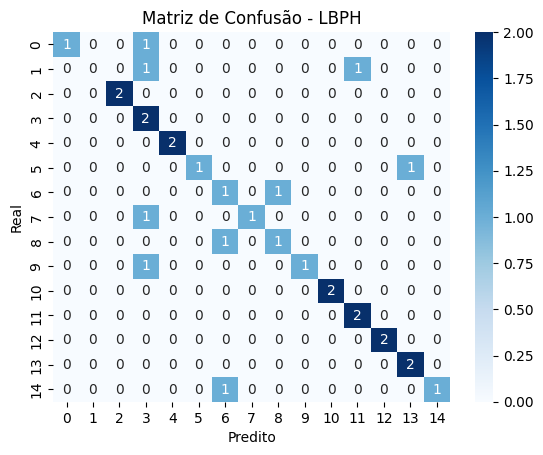

In [16]:
# 5MAIN - Matriz de Confusão do LBPH

cm = confusion_matrix(saidas_esperadas, previsoes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão - LBPH")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()


In [17]:
# 6MAIN - Inicialização do detector, pontos e modelo de descritor facial

detector_face = dlib.get_frontal_face_detector()
detector_pontos = dlib.shape_predictor(shape_predictor_path)
descritor_facial_extrator = dlib.face_recognition_model_v1(resnet_model_path)


In [18]:
# 7MAIN - Extração de descritores faciais com Dlib

descritores_faciais = []
index = {}
idx = 0

for f in os.listdir(train_path):
    path_img = os.path.join(train_path, f)
    image = Image.open(path_img).convert('RGB')
    image_np = np.array(image)
    detec = detector_face(image_np, 1)
    for face in detec:
        pontos = detector_pontos(image_np, face)
        descritor = descritor_facial_extrator.compute_face_descriptor(image_np, pontos)
        descritor = np.array(descritor, dtype=np.float64)[np.newaxis, :]
        descritores_faciais.append(descritor)
        index[idx] = path_img
        idx += 1

descritores_faciais = np.vstack(descritores_faciais)
print(f"Total de descritores extraídos: {descritores_faciais.shape[0]}")


Total de descritores extraídos: 132


In [19]:
# 8MAIN - Avaliação com Dlib + distância Euclidiana

previsoes_dlib = []
saidas_dlib = []

for f in os.listdir(test_path):
    img_path = os.path.join(test_path, f)
    image = Image.open(img_path).convert('RGB')
    image_np = np.array(image)
    detec = detector_face(image_np, 1)
    for face in detec:
        pontos = detector_pontos(image_np, face)
        descritor = descritor_facial_extrator.compute_face_descriptor(image_np, pontos)
        descritor = np.array(descritor, dtype=np.float64)[np.newaxis, :]
        distancias = np.linalg.norm(descritor - descritores_faciais, axis=1)
        idx_min = np.argmin(distancias)
        if distancias[idx_min] <= 0.5:
            pred_name = int(os.path.basename(index[idx_min]).split('.')[0].replace('subject', ''))
        else:
            pred_name = -1  # desconhecido
        real = int(f.split('.')[0].replace('subject', ''))
        previsoes_dlib.append(pred_name)
        saidas_dlib.append(real)

acc_dlib = accuracy_score(saidas_dlib, previsoes_dlib)
print("Acurácia com Dlib + ResNet:", acc_dlib)


Acurácia com Dlib + ResNet: 1.0
